In [10]:
import pyodbc
import pandas as pd
import geopandas as gpd
import rioxarray
import xarray as xr
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
import math



In [2]:

print("Loading elevation dataset...")
elevation_dataset = rioxarray.open_rasterio(r"../local_dataset/dataset/elevation_full.tif", masked=True)
elevation_dataset = elevation_dataset[0]

print("Loading soil dataset...")
soil_dataset = pd.read_parquet(r"../local_dataset/dataset/soil_full.parquet", engine="fastparquet")

print("Loading merged dataset...")
merged_dataset = pd.read_parquet(r"../local_dataset/dataset/merged.parquet", engine="fastparquet")

# print("Loading fire dataset...")
# fire_dataset = pd.read_parquet(r"../local_dataset/dataset/fire_full.parquet", engine="fastparquet")




Loading elevation dataset...
Loading soil dataset...
Loading merged dataset...


In [3]:
print("Elevation dataset shape:", elevation_dataset.shape)
print(elevation_dataset.rio.crs)
print(elevation_dataset.dtype)
print("=============================\n" * 3, end='')
print("Soil dataset shape:", soil_dataset.shape)
print(soil_dataset.dtypes)
print("=============================\n" * 3, end='')
print("Merged dataset shape:", merged_dataset.shape)
print(merged_dataset.dtypes)
# print("Fire dataset shape:", fire_dataset.shape)
# print(fire_dataset.dtypes)

Elevation dataset shape: (4392, 4965)
EPSG:4326
float32
Soil dataset shape: (7109938, 24)
lon              float64
lat              float64
COARSE             int64
SAND               int64
SILT               int64
CLAY               int64
TEXTURE_USDA     float64
TEXTURE_SOTER     object
BULK             float64
REF_BULK         float64
ORG_CARBON       float64
PH_WATER         float64
TOTAL_N          float64
CN_RATIO         float64
CEC_SOIL           int64
CEC_CLAY           int64
CEC_EFF          float64
TEB              float64
BSAT               int64
ALUM_SAT           int64
ESP                int64
TCARBON_EQ       float64
GYPSUM           float64
ELEC_COND          int64
dtype: object
Merged dataset shape: (60463, 18)
lon                       float64
lat                       float64
fire                        int64
log_precip_s1             float64
log_precip_s2             float64
log_precip_s3             float64
log_precip_s4             float64
tmax_s1                 

# Preprocessing before merging

In [ ]:

merged_dataset = fire_dataset

# def snap_to_grid(values, grid_size):
#     return np.round(values / grid_size) * grid_size

# grid_size = 0.01

# print("Unique values before snapping:")
# print(fire_dataset["lon"].nunique(), fire_dataset["lat"].nunique())

# fire_dataset["lon"] = snap_to_grid(fire_dataset["lon"], grid_size)
# fire_dataset["lat"] = snap_to_grid(fire_dataset["lat"], grid_size)

# print("Unique values after snapping:")
# print(fire_dataset["lon"].nunique(), fire_dataset["lat"].nunique())


Unique values before snapping:
14440 14002
Unique values after snapping:
1924 1775


# Merge dataset with elevation

In [4]:
merged_dataset['elevation'] = elevation_dataset.sel(
    x=xr.DataArray(merged_dataset.lon, dims="points"),
    y=xr.DataArray(merged_dataset.lat, dims="points"),
    method="nearest"
).values
print("Merged dataset shape:", merged_dataset.shape)
print(merged_dataset.head())

Merged dataset shape: (60463, 19)
        lon       lat  fire  log_precip_s1  log_precip_s2  log_precip_s3  \
0   9.48947  31.49290     1            NaN            NaN            NaN   
1   9.49053  31.49524     1            NaN            NaN            NaN   
2   9.49368  31.49449     1            NaN            NaN            NaN   
3   9.49154  31.49420     1            NaN            NaN            NaN   
4  10.09115  36.93407     1      11.380727       6.419073        4.40628   

   log_precip_s4    tmax_s1  tmax_s2    tmax_s3  tmax_s4  \
0            NaN        NaN      NaN        NaN      NaN   
1            NaN        NaN      NaN        NaN      NaN   
2            NaN        NaN      NaN        NaN      NaN   
3            NaN        NaN      NaN        NaN      NaN   
4      10.856232  17.666667    21.75  34.833333     28.0   

   amplitude_thermique_s1  amplitude_thermique_s2  amplitude_thermique_s3  \
0                     NaN                     NaN                     N

# Merge dataset with soil

In [5]:

merged_coords = merged_dataset[["lon", "lat"]].to_numpy()

# dataset B = grid points (right table)
soil_coords = soil_dataset[["lon", "lat"]].to_numpy()

# Build KDTree on grid (right table)
tree = cKDTree(soil_coords)
print("KDTree built.")

# Query nearest neighbor for each fire point
dist, idx = tree.query(merged_coords, k=1)
print("Nearest neighbors queried.")

# idx = index of nearest grid point
# Attach grid attributes to fire_df
merged_dataset = pd.concat([
    merged_dataset.reset_index(drop=True),
    soil_dataset.drop(columns=["lon", "lat"]).iloc[idx.flatten()].reset_index(drop=True)
], axis=1)
print("Merged dataset with soil.")
print("Final merged dataset shape:", merged_dataset.shape)
print(merged_dataset.head())

KDTree built.
Nearest neighbors queried.
Merged dataset with soil.
Final merged dataset shape: (60463, 41)
        lon       lat  fire  log_precip_s1  log_precip_s2  log_precip_s3  \
0   9.48947  31.49290     1            NaN            NaN            NaN   
1   9.49053  31.49524     1            NaN            NaN            NaN   
2   9.49368  31.49449     1            NaN            NaN            NaN   
3   9.49154  31.49420     1            NaN            NaN            NaN   
4  10.09115  36.93407     1      11.380727       6.419073        4.40628   

   log_precip_s4    tmax_s1  tmax_s2    tmax_s3  ...  CEC_SOIL  CEC_CLAY  \
0            NaN        NaN      NaN        NaN  ...         4        61   
1            NaN        NaN      NaN        NaN  ...         4        61   
2            NaN        NaN      NaN        NaN  ...         4        61   
3            NaN        NaN      NaN        NaN  ...         4        61   
4      10.856232  17.666667    21.75  34.833333  ...    

In [ ]:
# Export final merged dataset

print("Exporting final merged dataset...")
merged_dataset.to_parquet(r"../local_dataset/dataset/merged_full.parquet", engine="fastparquet", index=False)



Exporting final merged dataset...
Loading merged dataset...
Merged dataset shape: (60463, 41)


,lon,lat,fire,log_precip_s1,log_precip_s2,log_precip_s3,log_precip_s4,tmax_s1,tmax_s2,tmax_s3,...,CEC_SOIL,CEC_CLAY,CEC_EFF,TEB,BSAT,ALUM_SAT,ESP,TCARBON_EQ,GYPSUM,ELEC_COND
count,60463.000000,60463.000000,60463.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,16308.000000,...,60463.000000,60463.000000,60463.000000,60463.000000,60463.000000,60463.000000,60463.000000,60463.000000,60463.000000,60463.00000
mean,3.847371,29.670255,0.252468,6.865051,5.859077,3.287224,7.062983,17.246400,25.641961,36.667945,...,13.062286,58.900964,23.686916,21.242413,92.315201,0.116336,5.391529,8.624423,2.640364,1.73483
std,4.313307,4.338887,0.434432,4.200755,3.288795,1.743078,3.425059,3.642815,4.689755,3.910938,...,4.314620,14.075734,23.750166,24.194720,13.424553,1.347472,10.217913,4.126010,6.647202,3.04174
min,-8.128050,19.593230,0.000000,0.000000,0.000000,0.000000,0.000000,6.250000,15.250000,27.500000,...,4.000000,16.000000,-9.000000,-9.000000,10.000000,0.000000,1.000000,0.000000,0.000000,0.00000
25%,0.711950,26.513230,0.000000,3.041900,2.789630,1.695615,3.989498,14.333333,21.875000,33.625000,...,13.000000,48.000000,-3.000000,-3.000000,97.000000,0.000000,3.000000,6.300000,0.300000,1.00000
50%,4.701950,30.073230,0.000000,6.719227,5.934454,3.558018,8.017608,17.083333,24.416667,36.083333,...,14.000000,61.000000,25.000000,19.000000,99.000000,0.000000,3.000000,8.900000,0.600000,1.00000
75%,7.021950,32.933230,1.000000,10.116704,8.941180,4.791940,9.951012,19.500000,29.250000,39.750000,...,14.000000,71.000000,37.000000,38.000000,100.000000,0.000000,3.000000,9.800000,3.300000,1.00000
max,11.111950,37.333230,1.000000,15.915413,12.047893,7.739901,13.038357,30.000000,42.000000,47.750000,...,41.000000,83.000000,143.000000,143.000000,100.000000,40.000000,67.000000,31.299999,57.599998,32.00000


# Check final merged dataset after export

Loading merged dataset...
Merged dataset shape: (60463, 41)


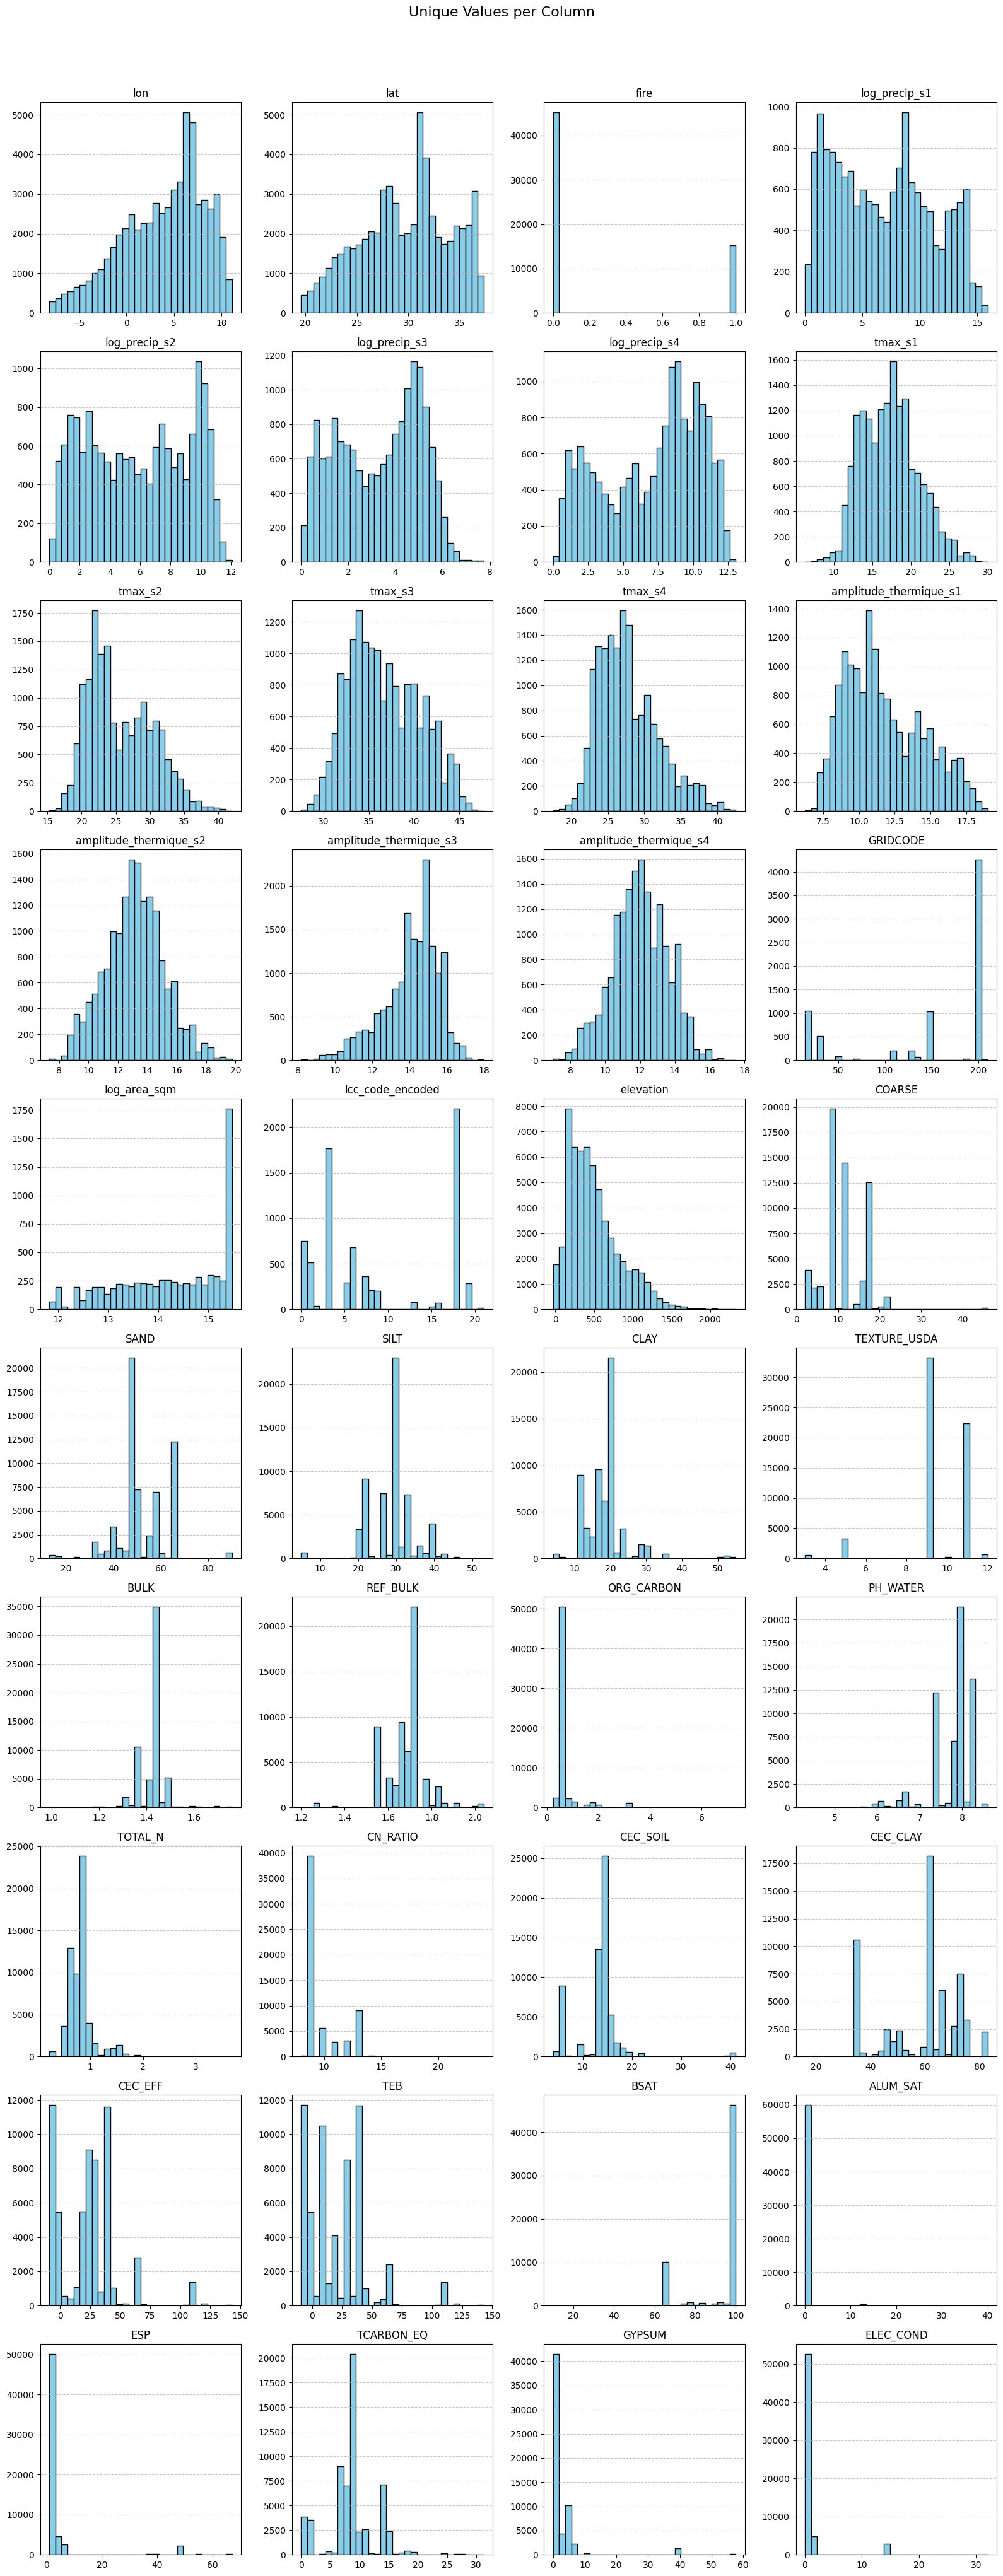

In [ ]:
print("Loading merged dataset...")
merged_dataset = pd.read_parquet(r"../local_dataset/dataset/merged_full.parquet", engine="fastparquet")
print("Merged dataset shape:", merged_dataset.shape)
merged_dataset.describe(include='all')

def plot_histograms(numeric_cols):
    cols_per_row = 4
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Unique Values per Column", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.hist(numeric_cols[col], bins=30, color='skyblue', edgecolor='black')
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_histograms(merged_dataset.select_dtypes(include=[np.number]))


In [12]:

print("Number of nan values per column:")
print(merged_dataset.isna().sum())

Number of nan values per column:
lon                           0
lat                           0
fire                          0
log_precip_s1             44155
log_precip_s2             44155
log_precip_s3             44155
log_precip_s4             44155
tmax_s1                   44155
tmax_s2                   44155
tmax_s3                   44155
tmax_s4                   44155
amplitude_thermique_s1    44155
amplitude_thermique_s2    44155
amplitude_thermique_s3    44155
amplitude_thermique_s4    44155
GRIDCODE                  52968
log_area_sqm              52968
lcc_code_encoded          52968
elevation                   928
COARSE                        0
SAND                          0
SILT                          0
CLAY                          0
TEXTURE_USDA                  0
TEXTURE_SOTER                 0
BULK                          0
REF_BULK                      0
ORG_CARBON                    0
PH_WATER                      0
TOTAL_N                       0
CN_RATI